## Introduction

In this notebook, we will preprocess CT scans of the lungs and their corresponding tumor masks for a segmentation task. 

The data comes from the **Medical Segmentation Decathlon** (Task 06 - Lung), and is provided in the [NIfTI format (.nii.gz)](https://nifti.nimh.nih.gov/). Each scan includes a 3D CT image and a manually segmented mask indicating tumor regions.

We will:
- Inspect and visualize volumetric data
- Crop, window, normalize and resize the CTs and masks
- Store them as individual 2D slices for fast loading
- Prepare the dataset for 2D segmentation with PyTorch

🔗 **Data license**: CC-BY-SA 4.0 – [Link](https://creativecommons.org/licenses/by-sa/4.0/)


## Imports

We begin by importing all the necessary libraries:

- `nibabel` for handling `.nii.gz` files (NIfTI format)
- `numpy` for numerical operations
- `matplotlib` and `celluloid` for visualization and animation
- `cv2` for resizing images
- `tqdm` for progress bars
- `Path` from `pathlib` for easier path handling

In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
import cv2


We define the paths to the training CT volumes (`imagesTr/`) and their corresponding labels (`labelsTr/`).

In [2]:
root = Path("../datos/imagesTr/")
label = Path("../datos/labelsTr/")

This function takes a CT file path and returns the path to its matching label file by replacing `imagesTr` with `labelsTr` in the folder structure.

In [3]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories whithin the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


Here we choose a random subject from the training set to explore its image and mask. This helps us understand the data before preprocessing it.

In [4]:
sample_path = list(root.glob("lung*"))[2]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [5]:
sample_path, sample_path_label

(WindowsPath('../datos/Task06_Lung/imagesTr/lung_004.nii.gz'),
 WindowsPath('../datos/Task06_Lung/labelsTr/lung_004.nii.gz'))

Using `nibabel`, we check the anatomical orientation of the volume to ensure all samples are aligned correctly.

In [6]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

In [7]:
nib.aff2axcodes(data.affine)

('L', 'A', 'S')

We use `matplotlib` and `celluloid` to animate the axial slices of a 3D CT scan. The tumor mask is overlaid in red (`autumn` colormap).

This provides a first look at how the tumor is distributed in the scan.

<IPython.core.display.Javascript object>


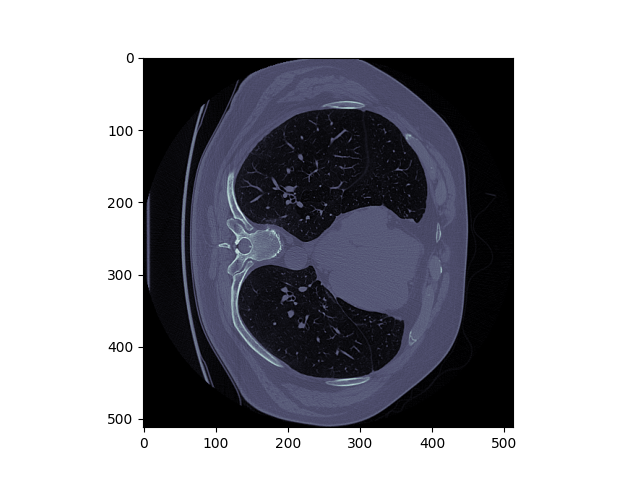

In [8]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, ct.shape[2], 2):  # axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    #plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [9]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video


C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


## Preprocessing
Before training a segmentation model on CT scans, it is essential to preprocess the raw intensity values appropriately. CT images are stored in Hounsfield Units (HU), which measure tissue density. The range of HU values in a scan can span from air (around -1000 HU) to dense bone (over +1000 HU), and even up to +3000 HU in some cases. However, most of this range is not relevant for lung tumor segmentation.

To focus on the structures of interest and reduce noise, we apply an intensity windowing operation. This operation clips the input HU values to a specified range and then normalizes the result to the [0, 1] interval.

For lung windowing, a common choice is:
- **Window level (center)**: -600
- **Window width (range)**: 1500

This window emphasizes the contrast between lung parenchyma, air, soft tissues, and potential tumor regions, while discarding irrelevant high-density structures like bones and implants.

Windowing is applied directly to the CT volume before normalization. It ensures that each slice input to the model focuses on meaningful anatomical regions.

In the preprocessing step, we will:
1. Load each 3D CT scan and its corresponding tumor mask.
2. Crop the lower part of the body by removing the first 30 axial slices, which typically correspond to the abdomen.
3. Apply the lung window to the CT volume.
4. Resize all axial slices and masks to 256×256 pixels to standardize input size and reduce training cost.
5. Store each slice and mask pair as `.npy` files in a consistent directory structure.

This approach enables fast 2D slice-level loading during training, improves learning focus, and prepares the data for segmentation using convolutional neural networks.

In [10]:
def apply_ct_window(image, level=100, width=600):
    """
    Applies a windowing transformation to a CT image in Hounsfield Units (HU).
    
    Args:
        image (np.ndarray): The input CT slice in HU.
        level (int): Center of the window (default: 100).
        width (int): Width of the window (default: 600).

    Returns:
        np.ndarray: The windowed image normalized to [0, 1].
    
    This operation:
    - Clips the pixel values to the range [level - width/2, level + width/2]
    - Scales the result linearly to [0, 1]
    
    This is commonly used to focus on specific tissues, such as lungs or soft tissue,
    by enhancing the contrast in relevant HU ranges.
    """
    min_hu = level - width // 2  # Lower bound of the window
    max_hu = level + width // 2  # Upper bound of the window
    windowed = np.clip(image, min_hu, max_hu)  # Clip values outside the window
    windowed = (windowed - min_hu) / width     # Normalize to [0, 1]
    return windowed


We plot an original slice vs. the windowed version to show the effect of the lung window. Tumor boundaries become more visible.

In [11]:
all_files = list(root.glob("lung_*"))  # Get all subjects

<IPython.core.display.Javascript object>


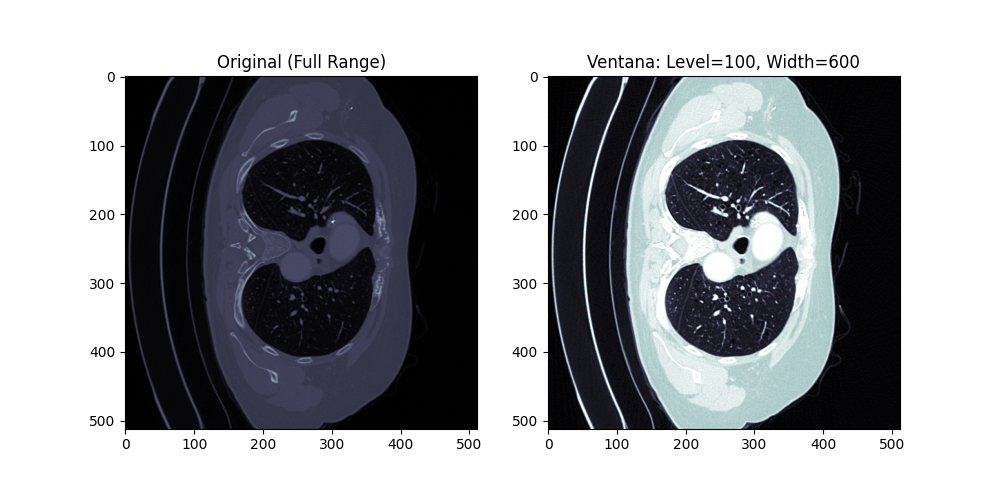

In [26]:
# Visualization example (using one slice from the first subject)

# Load the CT volume and apply initial cropping
sample_ct = nib.load(all_files[0]).get_fdata()[:, :, 30:]  # Crop lower 30 slices (abdomen)

# Select an axial slice to visualize
sample_slice = sample_ct[:, :, 180]

# Apply lung windowing
windowed_slice = apply_ct_window(sample_slice, level=-600, width=1500)

# Show comparison between raw and windowed versions
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_slice, cmap="bone")
axes[0].set_title("Original (Full Range)")
axes[1].imshow(windowed_slice, cmap="bone")
axes[1].set_title("Lung Window (Level=-600, Width=1500)")
plt.show()


In this main loop, we apply the full preprocessing pipeline to every subject:

In [27]:
save_root = Path("../datos/Preprocessed")

for counter, path_to_ct_data in enumerate(tqdm(all_files)):
        
    path_to_label = change_img_to_label_path(path_to_ct_data)  # Get path to ground truth
    
    # Load and extract corresponding data
    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()
      
    # 1. Crop y aplicar ventana pulmonar (¡sin normalizar a /3071!)
    ct_data = ct_data[:, :, 30:]  # Crop abdomen
    ct_data = apply_ct_window(ct_data, level=-600, width=1500)  # Aplicar ventana aquí
    label_data = label_data[:, :, 30:]
        
    # Check if train or val data and create corresponding path
    if counter < 57:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Loop over the slices in the full volume and store the data and labels in the data/masks directory
    for i in range(ct_data.shape[-1]):
        slice = ct_data[:,:,i]
        mask = label_data[:,:,i]
        
        # Resize slice and label to common resolution to reduce training time
        slice = cv2.resize(slice, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        # Dentro del bucle de preprocesamiento (cuando guardas los datos):
        np.save(slice_path/str(i), slice.astype(np.float32))  # Forzar float32
        np.save(mask_path/str(i), mask.astype(np.uint8))
        
        
    

  0%|          | 0/63 [00:00<?, ?it/s]

##  Validate Preprocessed Files

We load a specific slice from the saved `.npy` files and run several checks:

- Correct shape and dtype
- Value ranges for the CT slice
- Mask is binary
- No loading issues

Finally, we simulate how this data would look in a PyTorch batch and visualize the image, mask, and overlay.

=== Verificación para Entrenamiento ===
Slice: shape=(256, 256), dtype=float32, range=[0.217, 1.000]
Mask: shape=(256, 256), dtype=uint8, unique=[0]

--- ADVERTENCIAS ---
• Máscara vacía (sin tumor). Es válido si hay otras slices con tumor.

✓ Todas las verificaciones pasaron correctamente

=== Simulación de Batch ===
Slices batch: torch.Size([2, 1, 256, 256]) | dtype: torch.float32
Masks batch: torch.Size([2, 1, 256, 256]) | dtype: torch.int64


<IPython.core.display.Javascript object>


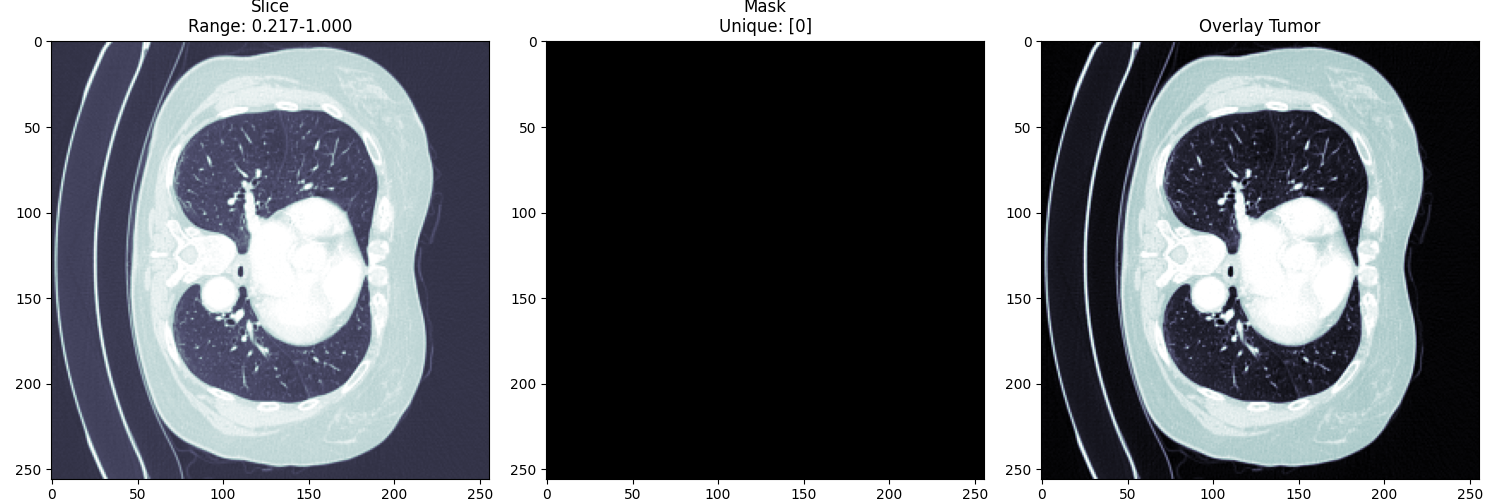

In [28]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch

# --- Configuration ---
sample_subject = Path("../datos/Preprocessed/train/0")  # Change if needed
sample_slice_idx = 100  # Index of slice to inspect

# --- 1. Load sample slice and mask with file existence check ---
try:
    slice = np.load(sample_subject / "data" / f"{sample_slice_idx}.npy").astype(np.float32)
    mask = np.load(sample_subject / "masks" / f"{sample_slice_idx}.npy")
except FileNotFoundError:
    raise FileNotFoundError("File not found. Please verify your preprocessing output path.")

# --- 2. Data integrity checks ---
def check_data_integrity(slice, mask):
    """Check types, shapes, and value ranges for the slice and mask."""
    errors = []
    warnings = []

    # Shape check
    if slice.shape != (256, 256):
        errors.append(f"Expected slice shape (256, 256), got {slice.shape}")
    if mask.shape != (256, 256):
        errors.append(f"Expected mask shape (256, 256), got {mask.shape}")

    # Data type check
    if slice.dtype != np.float32:
        errors.append(f"Expected slice dtype float32, got {slice.dtype}")
    if mask.dtype not in (np.uint8, np.int64):
        warnings.append(f"Recommended mask dtype is uint8 or int64, got {mask.dtype}")

    # Value range check
    if not (0 <= slice.min() and slice.max() <= 1.0):
        errors.append(f"Slice values out of [0, 1] range: [{slice.min():.3f}, {slice.max():.3f}]")

    # Mask content check
    mask_values = np.unique(mask)
    if len(mask_values) == 1 and mask_values[0] == 0:
        warnings.append("Empty mask (no tumor). Valid if other slices contain tumor.")
    elif not np.array_equal(mask_values, np.array([0, 1])):
        errors.append(f"Mask is not binary. Found values: {mask_values}")

    return errors, warnings

errors, warnings = check_data_integrity(slice, mask)

# --- 3. Print report ---
print("=== Data Verification ===")
print(f"Slice: shape={slice.shape}, dtype={slice.dtype}, range=[{slice.min():.3f}, {slice.max]()


##  Dataset Quality Check: Mask Distribution

Some slices have no tumor. We count how many masks are empty (background only) vs. non-empty.

This helps assess class imbalance, which is very common in medical datasets.

In [29]:
import numpy as np
from pathlib import Path
from tqdm import tqdm

def check_empty_masks(dataset_path, num_samples_to_check=None):
    """
    Check how many masks in the dataset are empty (i.e., contain no tumor).
    
    Args:
        dataset_path (str or Path): Path to the 'train/' or 'val/' folder.
        num_samples_to_check (int or None): Number of masks to check. If None, check all.
    
    Raises:
        ValueError: If all masks are empty.
    """
    # Collect all mask file paths
    mask_files = list(Path(dataset_path).glob("*/masks/*.npy"))
    if num_samples_to_check:
        mask_files = mask_files[:num_samples_to_check]

    empty_count = 0
    non_empty_count = 0

    # Count empty vs non-empty masks
    for mask_file in tqdm(mask_files, desc="Checking masks"):
        mask = np.load(mask_file)
        if np.all(mask == 0):
            empty_count += 1
        else:
            non_empty_count += 1

    # Print results
    print(f"\nResults:")
    print(f"- Empty masks: {empty_count}")
    print(f"- Non-empty masks (with tumor): {non_empty_count}")
    print(f"- Percentage of empty masks: {empty_count / (empty_count + non_empty_count) * 100:.2f}%")

    # Raise warning if all masks are empty
    if non_empty_count == 0:
        raise ValueError("All masks are empty. Check your preprocessing pipeline.")

# Example usage: check 1000 random slices from the training set
check_empty_masks("../datos/Preprocessed/train/", num_samples_to_check=1000)


Verificando máscaras: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 319.11it/s]


Resultados:
- Mascaras vacías: 946
- Mascaras con tumor: 54
- Porcentaje vacías: 94.60%


Nice! Everything is processed and we can continue to write the Dataset Class!